In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
data = torch.load("../../../data/preprocessed_data/dataset_155.pt")

/tmp/ipykernel_25459/1568903081.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("../../../data/preprocessed_data/dataset_155.pt")


In [4]:
nf = data['near_fields']
nf.shape

torch.Size([100, 2, 166, 166, 63])

In [5]:
def get_radial_profile(field, rho, radial_bin_edges, num_bins):
    """Computes 1D radial profiles (annular binning) of an input field.
    
    Parameters
    ----------
    field (torch.tensor): Input field of shape [xdim, ydim]
    rho (torch.tensor): Polar rho component
    radial_bin_edges (torch.tensor): binning setup
    num_bins (int): number of bins for the radial profiling.
    """
    H, W = field.shape
    
    # 1. Get spatial amplitude map
    magnitude_maps = torch.abs(field)
    
    # Ensure DC is at center for coordinate calculations:
    mag_maps_shifted = torch.fft.fftshift(magnitude_maps, dim=(-2, -1))
    
    radial_hist = torch.zeros(num_bins, device=field.device)    
    for i in range(num_bins):
        mask = (rho >= radial_bin_edges[i]) & (rho < radial_bin_edges[i+1])
        # summing over (H,W) dims
        radial_hist[i] = torch.sum(mag_maps_shifted * mask, dim=(-2,-1))

    # Normalize
    epsilon = 1e-10
    radial_hist_norm = radial_hist / (torch.sum(radial_hist) + epsilon)
    return radial_hist_norm

def get_angular_profile(field, theta, angle_bin_edges, num_bins):
    """Computes 1D angular profiles of an input field.
    
    Parameters
    ----------
    field (torch.tensor): Input field of shape [xdim, ydim]
    theta (torch.tensor): Polar theta component
    angle_bin_edges (torch.tensor): binning setup
    num_bins (int): number of bins for the angular profiling.
    """
    H, W = field.shape
    
    # 1. Get spatial amplitude map
    magnitude_maps = torch.abs(field)
    
    # Ensure DC is at center for coordinate calculations:
    mag_maps_shifted = torch.fft.fftshift(magnitude_maps, dim=(-2, -1))
    
    angle_hist = torch.zeros(num_bins, device=field.device)
    for i in range(num_bins):
        if i == num_bins - 1:
            mask_angle = (theta >= angle_bin_edges[i]) & (theta <= angle_bin_edges[i+1])
        else:
            mask_angle = (theta >= angle_bin_edges[i]) & (theta < angle_bin_edges[i+1])
        angle_hist[i] = torch.sum(mag_maps_shifted * mask_angle, dim=(-1, -2))
    
    # Normalize
    epsilon = 1e-10
    angle_hist_norm = angle_hist / (torch.sum(angle_hist) + epsilon)
    return angle_hist_norm

def precompute_polar_coordinates(H, W, device):
    y = torch.arange(0, H, device=device, dtype=torch.float32)
    x = torch.arange(0, W, device=device, dtype=torch.float32)
    y_indices, x_indices = torch.meshgrid(y, x, indexing='ij')
    crow, ccol = H // 2, W // 2
    x_coords = x_indices - ccol
    y_coords = y_indices - crow
    rho = torch.sqrt(x_coords**2 + y_coords**2) # (H, W)
    theta = (torch.arctan2(y_coords, x_coords) * 180 / torch.pi) % 360 # (H, W)
    return rho, theta

In [ ]:
num_bins = 100

def mse(field1, field2):
    return torch.mean(torch.abs(field1 - field2)**2)

def kMag(field1, field2):
    """k-space magnitude loss. Calculates MSE between magnitudes of k-space fields"""
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    mag_f1_k = torch.abs(field1_k)
    mag_f2_k = torch.abs(field2_k)
    return torch.mean((torch.log1p(mag_f1_k) - torch.log1p(mag_f2_k))**2)

def kPhase(field1, field2):
    """k-space phase loss. Calculates MSE of wrapped phase difference between fields"""
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    phase_f1_k = torch.angle(field1_k)
    phase_f2_k = torch.angle(field2_k)
    phase_diff = phase_f1_k - phase_f2_k
    wrapped_phase_diff = torch.atan2(torch.sin(phase_diff), torch.cos(phase_diff))
    weights = torch.log1p(torch.abs(field1_k) * torch.abs(field2_k))
    weights = weights / (torch.max(weights) + 1e-8)
    return torch.mean(weights * wrapped_phase_diff**2)

def kRadial(field1, field2):
    """k-space radial loss. Returns the MSE of radial profiles (annular binning) between fields"""
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    h, w = field1_k.shape
    radial_bin_edges = torch.linspace(0, torch.hypot(torch.tensor(h/2), torch.tensor(w/2)).item(), num_bins + 1, device=field1_k.device)
    polar_coords = precompute_polar_coordinates(h, w, field1_k.device)
    f1_k_radial = get_radial_profile(field1_k, polar_coords[0], radial_bin_edges, num_bins)
    f2_k_radial = get_radial_profile(field2_k, polar_coords[0], radial_bin_edges, num_bins)
    return torch.mean((f1_k_radial.float().to(field1_k.device) - 
                        f2_k_radial.float().to(field1_k.device))**2)

def kAngular(field1, field2):
    """k-space angular loss. Returns the MSE of angular profiles between fields."""
    field1_k = torch.fft.fft2(field1, norm="ortho")
    field2_k = torch.fft.fft2(field2, norm="ortho")
    h, w = field1_k.shape
    angle_bin_edges = torch.linspace(0, 360, num_bins + 1, device=field1_k.device)
    polar_coords = precompute_polar_coordinates(h, w, field1_k.device)
    gt_k_angular = get_angular_profile(field1_k, polar_coords[1], angle_bin_edges, num_bins)
    pred_k_angular = get_angular_profile(field2_k, polar_coords[1], angle_bin_edges, num_bins)
    return torch.mean((gt_k_angular.float().to(field1_k.device) - 
                        pred_k_angular.float().to(field1_k.device))**2)
    
def aggregate(field1, field2):
    # sort of redundant but good for udnerstanding all contributions
    tensor = torch.tensor((1*(kMag(field1, field2)),
                      1*(kPhase(field1, field2)), 
                      1*(kRadial(field1, field2)), 
                      1*(kAngular(field1, field2))))
    return torch.mean(tensor)

In [7]:
def plot_delta_field_dissimilarity(metrics, field_volume, method="grow"):
    """Plots field slice similarity across a larger field volume with various metrics
    
    Parameters
    ----------
    metrics (List): A list of functions
    field_volume (torch.Tensor): The full (2, 166, 166, 63) field volume (two fields)
    method (str) (Optional): Type of measurement. 'grow' or 'sliding' supported
    """
    real = field_volume[0]
    imag = field_volume[1]
    fields = torch.complex(real, imag) # [166,166,63]
    
    # iterate through to get the values
    for func in metrics:
        vals = []
        if method == "grow":
            for i in range(fields.shape[-1]):
                vals.append(func(fields[:, :, 0], fields[:, :, i]))
        elif method == "sliding":
            for i in range(fields.shape[-1] - 1):
                vals.append(func(fields[:, :, i], fields[:, :, i+1]))
        vals = np.array(vals)
        vals = (vals - np.min(vals)) / (np.max(vals) - np.min(vals))
        plt.plot(vals, label=func.__name__)
     
    # plot specs    
    plt.title(f"normalized field volume similarity - method: {method}")
    plt.xlabel("Step")
    plt.ylabel("Metric Value")
    plt.legend()
    plt.show()
    

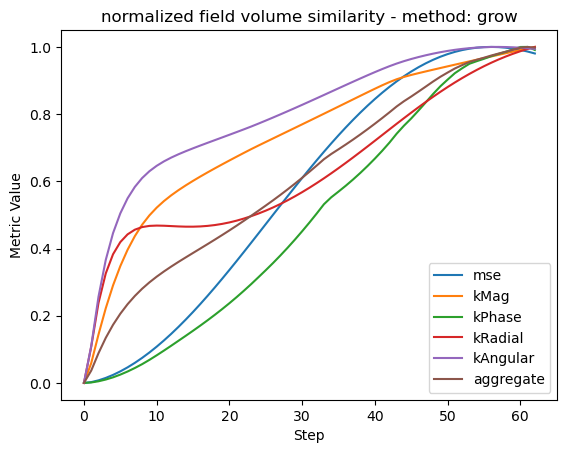

In [49]:
metrics = [mse, kMag, kPhase, kRadial, kAngular, aggregate]
plot_delta_field_dissimilarity(metrics, nf[0], method="grow")

In [38]:
import pandas as pd
import os

def cartesian_to_polar(real, imag):
    """
    Convert cartesian fields to polar fields
    
    Returns:
    - mag: Magnitude of the field
    - phase: Phase of the field
    """
    complex = torch.complex(real, imag)
    mag = torch.abs(complex)
    phase = torch.angle(complex)
    return mag, phase

def create_dft_plot_artifact(
    field_volume: torch.Tensor,
    artifacts_dir: str
) -> None:
    """
    A custom MLflow metric function for generating and saving DFT field plots.
    """
    print(f"Generating custom DFT plot for sample...")
    
    # extract the data for the specified sample
    real = field_volume[0]
    imag = field_volume[1]
    #field = torch.complex(real, imag) # (166, 166, 63)
    mag, phase = cartesian_to_polar(real, imag)

    # setup specified increments
    T = real.shape[2] # seq len
    indices_to_plot = [t for t in range(T) if t < 3 or (t - 2) % 10 == 0]
    num_plots = len(indices_to_plot)
    
    # Create figure WITHOUT creating subplots
    fig = plt.figure(figsize=(6*num_plots + 2, 16))
    
    # Create gridspec with space for labels and column headers
    gs = fig.add_gridspec(3, num_plots + 1,  # 3 rows: header + 2 data row
                        width_ratios=[0.3] + [1]*num_plots,
                        height_ratios=[0.05] + [1]*2,
                        hspace=0.1,
                        wspace=0.1)
    
    # Create axes for column headers
    header_axs = [fig.add_subplot(gs[0, j]) for j in range(1, num_plots + 1)]
    
    # Create axes for images
    axs = [[fig.add_subplot(gs[i+1, j]) for j in range(1, num_plots + 1)] 
        for i in range(2)]
    
    # Create axes for row labels
    label_axs = [fig.add_subplot(gs[i+1, 0]) for i in range(2)]
    
    title = "DFT Field Progression - Random Test Sample"
    fig.suptitle(title, fontsize=24, y=0.95, fontweight='bold')
    fig.text(0.5, 0.94, "plotplot", ha='center', fontsize=16)
    
    # Add column headers
    for slice_num, ax in zip(indices_to_plot, header_axs):
        ax.axis('off')
        ax.text(0.5, 0.3,
            f'slice {slice_num}',
            ha='center',
            va='center',
            fontsize=30,
            fontweight='bold')
    
    # Add row labels
    row_labels = ['True Magnitude', 'True Phase']
    
    for ax, label in zip(label_axs, row_labels):
        ax.axis('off')
        ax.text(0.95, 0.5, 
            label,
            ha='right',
            va='center',
            fontsize=20,
            fontweight='bold')
    
    # Plot sequence
    for plot_idx, t in enumerate(indices_to_plot):
        if t < 3 or (t-2) % 10 == 0: # first 3 then every fifth
            axs[0][plot_idx].imshow(mag[:, :, t], cmap='viridis')
            axs[0][plot_idx].axis('off')
            
            axs[1][plot_idx].imshow(phase[:, :, t], cmap='twilight_shifted')
            axs[1][plot_idx].axis('off')
        
    # save the artifact
    plot_path = os.path.join(artifacts_dir, "dft_comparison_idx_0.pdf")
    plt.tight_layout()
    plt.savefig(plot_path)
    plt.close(fig)
    print(f"Saved dft plot artifact to {plot_path}")
    
    return None

In [39]:
create_dft_plot_artifact(nf[0], '')

Generating custom DFT plot for sample...


/tmp/ipykernel_25459/444343794.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Saved dft plot artifact to dft_comparison_idx_0.pdf
